In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
from pandas import Series
from geopy.geocoders import Nominatim
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import gmplot


#importing the dataset using pandas
df = pd.read_csv("./911.csv")

#sample of original dataset
df.head(5)

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


In [2]:
#separate timeStamp data into 2 new columns
df['date'] = df.timeStamp.str[0:11]
df['time'] = df.timeStamp.str[-8:]

#Get rid of dummy 'e' column and 'timeStamp' column
del df['e']
del df['timeStamp']
#If time at end, then try to extract station number and impute
del df['desc']

#sample of dataset
#df.head(10)

In [3]:
#count number of values in each column
df.count()

lat      177755
lng      177755
zip      155957
title    177755
twp      177694
addr     177755
date     177755
time     177755
dtype: int64

In [4]:
#Finds total number of rows with missing values 
#Rows with more than one missing value only counted once
df.isnull().any(axis=1).sum()

21822

In [5]:
#Drop rows with missing zipcode values
df = df.dropna(subset=['zip'])

#Convert float values for zipcodes to integer type
df['zip'] = df['zip'].astype(int)
df.count()

lat      155957
lng      155957
zip      155957
title    155957
twp      155933
addr     155957
date     155957
time     155957
dtype: int64

In [6]:
empty = np.where(pd.isnull(df))
geolocator = Nominatim()
index = 0


#Impute 24 missing township values
for i in np.nditer(empty):
    
    #row of missing township cell
    row = empty[0][index] 
    #column of missing township cell
    column = empty[1][index]
    
    
    temp_lat = repr(df.iloc[row,0])
    temp_long = repr(df.iloc[row,1])
    
    
    location = geolocator.reverse([temp_lat, temp_long], timeout = 60)
    
    if column == 4:
        
    
        #extract township value from location dictionary
        town = location.raw['address']['city'] 
    
    
        #remove 'Township' ending from name of town    
        if town.endswith("Township"):
            town = town[0:-9]
            
        else:
            pass
                
        #convert to uppercase to maintain township format in dataframe    
        town = town.upper()
    
        #put imputed township name into corresponding missing cell of dataframe
        df.iloc[row, column] = town
    
        print(df.iloc[row, column])
        
    else:
        
        pass
        
        #Elected to comment out code to impute missing zipcodes because it would take too long (approx. 4-6 hrs.)
        #zcode = location.raw['address']['postcode']
        
        #df.iloc[row, column] = zcode
        
        #print(df.iloc[row, column])
    
        
    #increment index to get to next set of index values for empty township cell
    index += 1

UPPER MORELAND
WARRINGTON
NORRISTOWN
NORRISTOWN
MONTGOMERY
UPPER MERION
TOWAMENCIN
HATBORO
HORSHAM
HATFIELD
JENKINTOWN
LOWER MERION
FRANCONIA
HATBORO
POTTSTOWN
SKIPPACK
SKIPPACK
UPPER MORELAND
NORRISTOWN
NORRISTOWN
UPPER SALFORD
SPRINGFIELD
UPPER MERION
UPPER PROVIDENCE


In [7]:
df.count()

lat      155957
lng      155957
zip      155957
title    155957
twp      155957
addr     155957
date     155957
time     155957
dtype: int64

In [8]:
hour = df.time.str[0:2]
hour2 = pd.to_numeric(hour)

#If time of call is between 6PM and 6AM then it is classified as 'night', otherwise it is classified as 'day'

for i, row in df.iterrows():
    if(hour2.loc[i] >= 18 or hour2.loc[i] < 6):
        hour.at[i] = 'night'
    else:
        hour.at[i] = 'day'


In [9]:
#Replace military time with either 'night' or 'day'
del df['time']

df['time_of_day'] = hour

#df.head(10)   

In [10]:
#Change date format to weekdays format
df['dates'] = pd.to_datetime(df['date'])
df['weekday'] = df['dates'].dt.weekday_name

del df['date']
del df['dates']

In [11]:
#Separate first part of 911 call classification from rest of title
df['class'], df['title2'] = df['title'].str.split(':', 1).str
del df['title']
del df['title2']


In [12]:
df.head(10)

,lat,lng,zip,twp,addr,time_of_day,weekday,class
0,40.297876,-75.581294,19525,NEW HANOVER,REINDEER CT & DEAD END,day,Thursday,EMS
1,40.258061,-75.264680,19446,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,day,Thursday,EMS
2,40.121182,-75.351975,19401,NORRISTOWN,HAWS AVE,day,Thursday,Fire
3,40.116153,-75.343513,19401,NORRISTOWN,AIRY ST & SWEDE ST,day,Thursday,EMS
5,40.253473,-75.283245,19446,LANSDALE,CANNON AVE & W 9TH ST,day,Thursday,EMS
6,40.182111,-75.127795,19044,HORSHAM,LAUREL AVE & OAKDALE AVE,day,Thursday,EMS
7,40.217286,-75.405182,19426,SKIPPACK,COLLEGEVILLE RD & LYWISKI RD,day,Thursday,EMS
8,40.289027,-75.399590,19438,LOWER SALFORD,MAIN ST & OLD SUMNEYTOWN PIKE,day,Thursday,EMS
9,40.102398,-75.291458,19462,PLYMOUTH,BLUEROUTE & RAMP I476 NB TO CHEMICAL RD,day,Thursday,Traffic
11,40.084161,-75.308386,19428,PLYMOUTH,BROOK RD & COLWELL LN,day,Thursday,Traffic


In [13]:
#unique zipcodes in the dataset
df.zip.unique()

array([19525, 19446, 19401, 19044, 19426, 19438, 19462, 19428, 19040,
       19027, 18936, 18974, 19031, 19403, 19422, 19085, 18964, 19038,
       19406, 19468, 19010, 19095, 19464, 19444, 19041, 19440, 19405,
       19002, 19096, 19454, 19465, 19004, 19066, 19072, 18041, 19046,
       19090, 19012, 19025, 19473, 18073, 18969, 18074, 19460, 19001,
       18054, 19009, 19006, 19035, 19150, 19075, 19034, 19151, 19453,
       19003, 18914, 19512, 18976, 19120, 18915, 18076, 19477, 19087,
       18966, 19131, 19128, 19083, 19053, 19475, 18960, 19504, 18070,
       19492, 18932, 19118, 18092, 19490, 19518, 18056, 19119, 19107,
       17752, 19111, 18927, 19435, 18951, 19472, 19503, 19126, 19505,
       19423, 19138, 36107, 18036, 19116, 19139, 19129, 19115, 19355,
       77316, 19457, 19082, 19127, 19443, 17555, 19520, 19063, 19020, 19404], dtype=int64)

In [14]:
#find the number of unique zipcodes
s = Series(df.zip)
zip_unique = s.unique().size
print(zip_unique)

109


In [15]:
#unique townships in the dataset
df.twp.unique()

array(['NEW HANOVER', 'HATFIELD TOWNSHIP', 'NORRISTOWN', 'LANSDALE',
       'HORSHAM', 'SKIPPACK', 'LOWER SALFORD', 'PLYMOUTH',
       'UPPER MORELAND', 'CHELTENHAM', 'MONTGOMERY', 'WHITEMARSH',
       'UPPER GWYNEDD', 'LOWER PROVIDENCE', 'WHITPAIN', 'DELAWARE COUNTY',
       'FRANCONIA', 'WEST CONSHOHOCKEN', 'UPPER MERION', 'LIMERICK',
       'DOUGLASS', 'LOWER MERION', 'POTTSTOWN', 'BRIDGEPORT', 'TOWAMENCIN',
       'AMBLER', 'LOWER POTTSGROVE', 'CHESTER COUNTY', 'UPPER HANOVER',
       'SPRINGFIELD', 'ROCKLEDGE', 'ABINGTON', 'WEST NORRITON',
       'ROYERSFORD', 'UPPER DUBLIN', 'UPPER SALFORD', 'CONSHOHOCKEN',
       'PENNSBURG', 'TELFORD', 'EAST NORRITON', 'UPPER FREDERICK',
       'UPPER PROVIDENCE', 'SALFORD', 'LEHIGH COUNTY', 'MARLBOROUGH',
       'BRYN ATHYN', 'LOWER MORELAND', 'HATBORO', 'LOWER GWYNEDD',
       'WORCESTER', 'COLLEGEVILLE', 'SCHWENKSVILLE', 'SOUDERTON',
       'PERKIOMEN', 'LOWER FREDERICK', 'BUCKS COUNTY', 'RED HILL',
       'WEST POTTSGROVE', 'UPPER POTTSGROV

In [16]:
#find the number of unique townships
s2 = Series(df.twp)
twp_unique = s2.unique().size
print(twp_unique)

70


In [17]:
#find the number of unique address locations
s4 = Series(df.addr)
s4.unique().size

25162

In [18]:
sLat = Series(df.lat)
sLat.unique().size

16968

In [19]:
sLong = Series(df.lng)
sLong.unique().size

16992

In [20]:
sLat.max()

41.167156499999997

In [21]:
sLat.min()

30.333596000000004

In [22]:
sLong.max()

-74.957972900000001

In [23]:
sLong.min()

-95.595594700000007

In [24]:
#Change string data to label encoded integers for RandomForestClassifier()
le_dow = preprocessing.LabelEncoder()
le_tod = preprocessing.LabelEncoder()
le_addr = preprocessing.LabelEncoder()
le_twp = preprocessing.LabelEncoder()
le_class = preprocessing.LabelEncoder()

le_dow = le_dow.fit_transform(df['weekday'])
le_tod = le_tod.fit_transform(df['time_of_day'])
le_addr = le_addr.fit_transform(df['addr'])
le_twp = le_twp.fit_transform(df['twp'])
le_class = le_class.fit_transform(df['class'])

In [25]:
#Create copy of dataframe
df2 = df

#Delete old columns with string values and replace with new label encoded columns
del df2['weekday']
del df2['time_of_day']
del df2['addr']
del df2['twp']
del df2['class']


df2['weekday'] = le_dow
df2['time_of_day'] = le_tod
df2['addr'] = le_addr
df2['twp'] = le_twp
df2['class'] = le_class

df2.head(10)

,lat,lng,zip,weekday,time_of_day,addr,twp,class
0,40.297876,-75.581294,19525,4,0,18187,35,0
1,40.258061,-75.264680,19446,4,0,2398,19,0
2,40.121182,-75.351975,19401,4,0,9768,36,1
3,40.116153,-75.343513,19401,4,0,615,36,0
5,40.253473,-75.283245,19446,4,0,3245,22,0
6,40.182111,-75.127795,19044,4,0,12164,20,0
7,40.217286,-75.405182,19426,4,0,4540,48,0
8,40.289027,-75.399590,19438,4,0,13272,31,0
9,40.102398,-75.291458,19462,4,0,2201,41,2
11,40.084161,-75.308386,19428,4,0,2606,41,2


In [26]:
#Split attributes for prediction input and classification attribute
x = df2[['lat', 'lng', 'zip', 'twp', 'addr', 'time_of_day', 'weekday']].copy()
y = df2[['class']].copy()


In [27]:
x.head(5)

,lat,lng,zip,twp,addr,time_of_day,weekday
0,40.297876,-75.581294,19525,35,18187,0,4
1,40.258061,-75.264680,19446,19,2398,0,4
2,40.121182,-75.351975,19401,36,9768,0,4
3,40.116153,-75.343513,19401,36,615,0,4
5,40.253473,-75.283245,19446,22,3245,0,4


In [28]:
y.head(5)

,class
0,0
1,0
2,1
3,0
5,0


In [29]:
#Split into training and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

forest = RandomForestClassifier(n_estimators=100, criterion='entropy', max_features=5, max_depth=25, min_impurity_split=1e-1, n_jobs=-1, random_state=0)

#Create random forest classifier with data
forest.fit(x_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=25, max_features=5, max_leaf_nodes=None,
            min_impurity_split=0.1, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [30]:
print("Accuracy on training set: {:.3f}".format(forest.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(x_test, y_test)))

Accuracy on training set: 0.872
Accuracy on test set: 0.663


In [31]:
important = forest.feature_importances_
print 'Feature importance:\n'

#Print importance value for each feature
for i in range(7):
    print df2.columns.values[i],': ',important[i], '\n'
    

Feature importance:

lat :  0.209996265491 

lng :  0.214763181336 

zip :  0.0336942675468 

weekday :  0.0367686954923 

time_of_day :  0.293123749589 

addr :  0.0203383626645 

twp :  0.19131547788 



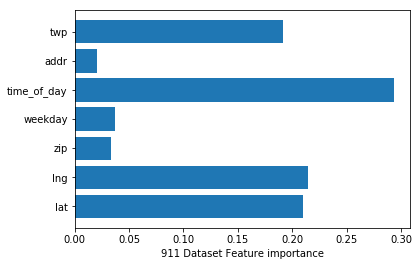

In [32]:
n_features = 7
names = []

for i in range(n_features):
    names.append(df2.columns.values[i])

#Plot importance of attributes for Random Forest Classifier
plt.barh(range(n_features), forest.feature_importances_, align='center')
plt.yticks(np.arange(n_features), names)
plt.xlabel("911 Dataset Feature importance")

In [82]:
#Arrays for all latitudes and longitudes 
lats = []
longs = []

#Arrays for latitude and longitude of each different 911 call type
ems_lat = []
ems_long = []
fire_lat = []
fire_long = []
traffic_lat = []
traffic_long = []


#Put latitute and longitude of 911 calls into arrays for maps
for i in range(155957):
    lats.append(df2.iloc[i, 0])
    longs.append(df2.iloc[i, 1])
    
    #911 call for EMS
    if df2.iloc[i, 7] == 0:
        ems_lat.append(df2.iloc[i, 0])
        ems_long.append(df2.iloc[i, 1])
    
    #911 call for Fire
    elif df2.iloc[i, 7] == 1:
        fire_lat.append(df2.iloc[i, 0])
        fire_long.append(df2.iloc[i, 1])
    
    #911 call for Traffic
    else:
        traffic_lat.append(df2.iloc[i, 0])
        traffic_long.append(df2.iloc[i, 1])

In [83]:
#Latitudes and Longitudes for plotting boundaries of Montgomery County Pennsylvania
lat_bound = (40.241979, 40.447123, 40.138185, 40.069056, 40.063658, 40.046278, 40.084713, 
40.073154, 40.092990, 40.054093, 40.011573, 39.977010, 40.019547, 40.015951, 40.072212, 
40.060884, 40.097123, 40.090095, 40.094000, 40.087753, 40.115236, 40.126164, 40.129910,
40.147977, 40.194150, 40.223927, 40.236395, 40.241979)

long_bound = (-75.696874, -75.529820, -75.015042, -75.096642, -75.087832, -75.110155,
-75.176633, -75.188473, -75.223789, -75.264413, -75.206578, -75.276598, -75.311506, 
-75.320488, -75.367236, -75.392806, -75.420365, -75.437921, -75.440779, -75.456498, 
-75.471208, -75.463654, -75.500604, -75.524058, -75.569582, -75.608164, -75.687167, -75.696874)                    


#Create map centered at lat, long, amount of zoom
gmap = gmplot.GoogleMapPlotter(40.194126, -75.362524, 8.5)

#Plot outline of Montgomery County
gmap.plot(lat_bound, long_bound, 'cornflowerblue', edge_width=5)

#Plot 911 call location in heatmap form
gmap.heatmap(lats, longs)

#Save html file of Google map
gmap.draw("Montgomery_County_Heatmap.html")

In [90]:
#Create map centered at lat, long, amount of zoom
gmap2 = gmplot.GoogleMapPlotter(40.194126, -75.362524, 10)

#Plot outline of Montgomery County
gmap2.plot(lat_bound, long_bound, 'cornflowerblue', edge_width=5)

#Plot first 10000 EMS, Fire, and Traffic 911 call locations onto map (30000 call locations total)
#EMS = green
gmap2.scatter(ems_lat[0:10000],ems_long[0:10000] , 'g', 5, marker=False)
#Fire = red
gmap2.scatter(fire_lat[0:10000],fire_long[0:10000] , 'r', 5, marker=False)
#Traffic = yellow
gmap2.scatter(traffic_lat[0:10000],traffic_long[0:10000] , 'y', 5, marker=False)


#Save html file of Google map
gmap2.draw("911_Call_Locations.html")